## Deep Learning Projectile Motion Solver
This notebook implements an artifical neural network to solve projectile motion problems when only three of the variables x, y, v0x, v0y, vy, and t are known. An solution engine utilizing kinematic equations of motion is used to calculate exact solutions to problems used to both train the neural network and evaluate the accuracy of its results. The domain of the problems is constrained to simplify the coding of the exact solution engine. Specifically, v0x and v0y are always >=0, y is always <=0, and vy is always an unkown. 

### Import useful packaged including TensorFlow 2.0 and Keras.
The notebook utilizes tensorflow >= 2.0, which now includes keras, a package of high level wrappers designed to make building and training deep learning models easier. 

In [1]:
# import packages
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

### Check to see if a Tensorflow is installed with GPU support and if a GPU is available.

In [2]:
if not tf.test.is_gpu_available():
    print('No GPU found. Training will be slower.')
else:
    print('Default GPU {} found.'.format(tf.test.gpu_device_name()))

Default GPU /device:GPU:0 found.


### Define helper functions.

In [3]:
# randomly select a set of three knowns and set all unknowns initially to zero.
def seed_inputs():

    # need at least one known for the x-dimension, and one from the y dimension, but three in all.
    # to make imaginary and multiple solutions impossible, voy and v0x are always >=0, 
    # y is always <= 0, and vy is always unknown.
    variables = ['x', 'y', 'v0x', 'v0y', 'vy', 't'] 
    knowns = random.sample(['v0x', 'x'],1) + random.sample(['v0y', 'y'],1)
    remaining = set(['x','y','v0x','v0y','t']).difference(set(knowns))
    knowns = knowns + random.sample(remaining,1)
    vals = [round(random.uniform(0,1000),2), round(random.uniform(0,-500),2), 
            round(random.uniform(50,100),2), round(random.uniform(50,100),2), 
            round(random.uniform(0,-100),2), round(random.uniform(5,20),2)]
    ins = {variables[i]: vals[i] for i in range(len(variables))}

    for key in ins:
        if not key in knowns:
            ins[key] = 0
    
    return knowns, ins

# engine to solve projectile motion problem using kinematic equations of motion.
# this may not be the most efficient or ellagent implementation but it works.
def solve_projectile(knowns, ins):
    outs = dict.copy(ins)
    g = -9.8


    if 'x' in knowns and 'v0x' in knowns: # find t
        outs['t'] = outs['x']/outs['v0x'] 
        knowns = knowns + ['t']

    if not 'y' in knowns:
        if 'v0y' in knowns and 'vy' in knowns: # if not T
            outs['t'] = (outs['vy'] - outs['v0y'])/g
        elif 'v0y' in knowns and 't' in knowns: # if not VY
            outs['vy'] = outs['v0y'] + g*outs['t']
        elif 'vy' in knowns and 't' in knowns: # if not V0Y
            outs['v0y'] = outs['vy'] - g*outs['t']
        outs['y'] = outs['v0y']*outs['t'] + 0.5*g*outs['t']**2
    elif 'y' in knowns and 't' in knowns:
        outs['v0y'] = (outs['y'] - 0.5*g*outs['t']**2)/outs['t']
        outs['vy'] = outs['v0y'] + g*outs['t']
    elif 'y' in knowns and 'vy' in knowns:
        outs['v0y'] = np.sqrt(outs['vy']**2 - 2*g*outs['y']) # always positive
        outs['t'] = (outs['vy']-outs['v0y'])/g
    elif 'y' in knowns and 'v0y' in knowns:
        outs['vy'] = -np.sqrt(outs['v0y']**2 + 2*g*outs['y'])
        outs['t'] = (outs['vy']-outs['v0y'])/g
    if 'x' in knowns and not 'v0x' in knowns:
        outs['v0x'] = outs['x']/outs['t']
    
        
    if 'v0x' in knowns and not 'x' in knowns:
        outs['x'] = outs['v0x']*outs['t']

    
    for key in outs:
        outs[key] = round(outs[key],2)

    return outs

# generate N projectile motion problems and their solutions.
def generate_data(N):
    x = np.zeros((N,6))
    y = np.zeros((N,6))
    for ii in range(N):
        knowns, ins = seed_inputs()
        outs = solve_projectile(knowns, ins)
        x[ii,:] = list(ins.values())
        y[ii,:] = list(outs.values())
        
    return x, y

# function to test the solution engine so individual solutions can be checked for correctness.
def test_solution_engine():
    variables = np.array(['x', 'y', 'v0x', 'v0y', 'vy', 't'])
    knowns, ins = seed_inputs()
    outs = solve_projectile(knowns, ins)

    unknowns = list(set(variables).difference(set(knowns)))

    ins = list(ins.values())
    outs = list(outs.values())

    print('knowns:')
    for each in knowns:
        ii = list(np.where(variables==each))[0][0]
        print(each, '=', ins[ii])
    print('\nsolved uknowns:')
    for each in unknowns:
        ii = list(np.where(variables==each))[0][0]
        print(each, '=', outs[ii])
    
    return

# function to calculate a projectiles trajectory from v0x, v0y, and x
def calc_trajectory(solution):
    theta = np.arctan(solution['v0y']/solution['v0x'])
    v0 = np.sqrt(solution['v0x']**2 + solution['v0y']**2)
    xrange = np.arange(0,solution['x'],0.1)
    yrange = xrange*np.tan(theta) - 9.8*np.multiply(xrange,xrange)/(2*v0**2*np.cos(theta)**2)
    
    return xrange, yrange

### Run the following cell to test the solution engine.

In [4]:
test_solution_engine()

knowns:
x = 468.0
y = -487.5
v0y = 72.27

solved uknowns:
v0x = 23.66
t = 19.78
vy = -121.56


### Generate training, test, and validation data sets.

In [5]:
x_train, y_train = generate_data(50000)
x_test, y_test = generate_data(5000)
x_validate, y_validate = generate_data(5000)

### Define the ANN model graph.

In [6]:
# learning_rate is a hyperparameter
learning_rate = 0.0001

# four hidden layers - three fully connected and a dropout layer - and an output layer
# linear activation is utilized on the final layer to get numerical results commensurate with the type of 
# problem we are considering.
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=6))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.05))
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='linear'))

          
# the error function utilized is the sum of the mean squared error.
model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
          
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

history = AccuracyHistory()

### Train the model.

In [7]:
# hyperparameters
batch_size = 64
epochs = 64

# train the model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validate, y_validate),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)

Train on 50000 samples, validate on 5000 samples
Epoch 1/64
50000/50000 [==============================] - 2s 46us/sample - loss: 790923.4557 - accuracy: 0.9225 - val_loss: 17310.0560 - val_accuracy: 0.9334
Epoch 2/64
50000/50000 [==============================] - 2s 30us/sample - loss: 772039.3568 - accuracy: 0.9258 - val_loss: 13181.8041 - val_accuracy: 0.9296
Epoch 3/64
50000/50000 [==============================] - 2s 32us/sample - loss: 769984.8506 - accuracy: 0.9263 - val_loss: 12108.5631 - val_accuracy: 0.9298
Epoch 4/64
50000/50000 [==============================] - 2s 31us/sample - loss: 767370.6362 - accuracy: 0.9297 - val_loss: 12021.4125 - val_accuracy: 0.9398
Epoch 5/64
50000/50000 [==============================] - 2s 31us/sample - loss: 765401.8526 - accuracy: 0.9350 - val_loss: 10051.4580 - val_accuracy: 0.9506
Epoch 6/64
50000/50000 [==============================] - 2s 32us/sample - loss: 762975.0539 - accuracy: 0.9455 - val_loss: 10620.0884 - val_accuracy: 0.9592
Epo

50000/50000 [==============================] - 2s 31us/sample - loss: 591915.3942 - accuracy: 0.9722 - val_loss: 4833.4710 - val_accuracy: 0.9830
Epoch 53/64
50000/50000 [==============================] - 2s 31us/sample - loss: 577678.8341 - accuracy: 0.9736 - val_loss: 4181.8406 - val_accuracy: 0.9782
Epoch 54/64
50000/50000 [==============================] - 2s 33us/sample - loss: 582896.9283 - accuracy: 0.9712 - val_loss: 7126.7838 - val_accuracy: 0.9772
Epoch 55/64
50000/50000 [==============================] - 2s 33us/sample - loss: 575229.5686 - accuracy: 0.9731 - val_loss: 8580.1887 - val_accuracy: 0.9798
Epoch 56/64
50000/50000 [==============================] - 2s 31us/sample - loss: 570508.1719 - accuracy: 0.9723 - val_loss: 19140.8956 - val_accuracy: 0.9698
Epoch 57/64
50000/50000 [==============================] - 2s 32us/sample - loss: 566348.8801 - accuracy: 0.9725 - val_loss: 8086.6461 - val_accuracy: 0.9822
Epoch 58/64
50000/50000 [==============================] - 2s 3

### Graph the accuracy of the model using the training data set versus the validation data set.

Test loss: 10582.410112988282
Test accuracy: 0.9736


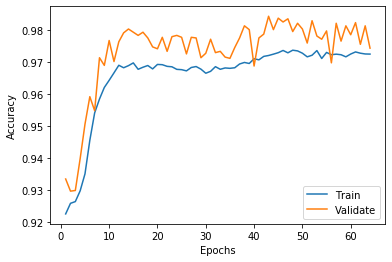

In [8]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1,epochs+1), history.acc, range(1,epochs+1), history.val_acc)
plt.legend(['Train','Validate'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Visualize solutions to the projectile motion problem predicted by the ANN
The solutions to the projectile motion problems predicted by the trained neural network are not exact solutions. In fact, the nature of the model can result in even the knowns fed into the network being adusted. So, each prediction made by the ANN from a set of three knowns acually defines a variety of trajectories, which are visualized here.

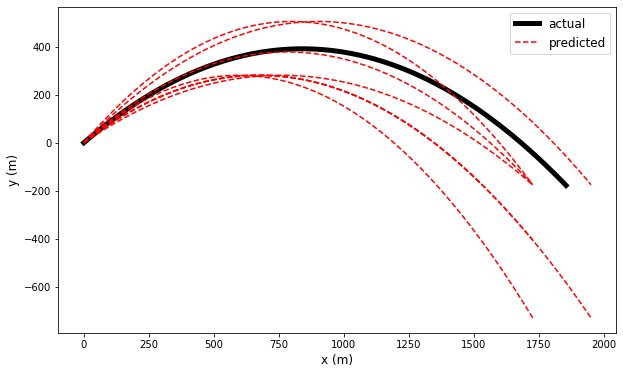

In [26]:
variables = np.array(['x', 'y', 'v0x', 'v0y', 'vy', 't'])
knowns, ins = seed_inputs()
outs = solve_projectile(knowns, ins)
outs_prime = model.predict([list(ins.values())])
outs_prime = {variables[i]: round(outs_prime[0][i],2) for i in range(len(variables))} # convert to dict
knowns_perms = [['v0x', 'v0y', 'x'], ['v0x', 'v0y', 'y'], ['v0x', 'v0y', 't'],
                ['v0x', 'y', 'x'], ['v0x', 'y', 't'],
                ['x', 'v0y', 'y'], ['x', 'v0y', 't'],
                ['x', 'y', 't']]
plt.figure(figsize=(10,6))

xr, yr = calc_trajectory(outs)
actual = plt.plot(xr, yr, 'k', linewidth=5)

for each in knowns_perms:
    solution = solve_projectile(each, outs_prime)
    xrange, yrange = calc_trajectory(solution)
    plt.plot(xrange,yrange,'r', linestyle='dashed')

plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)


legend_elements = [Line2D([0], [0], color='k', linewidth=5), Line2D([0], [0], color='r', linestyle='dashed')]
labels = ['actual','predicted']

plt.legend(legend_elements, labels, fontsize=12)
plt.savefig('projectile.png')
plt.show()